In [2]:
import numpy as np
import pbdlib as pbd
import matplotlib.pyplot as plt

import tf_oc as oc

from IPython.core import display
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

demos.py -f policy_001 -p $HOME/code/pbdlib/public/pbdlib/pop/data/tests/

3 without and with prior

5, 6, 7 without

In [3]:
demo_name = 'policy_006'

In [4]:
data = np.load('./data/tests/%s.npy' % demo_name)[()]

In [5]:
x_in = np.concatenate(data['x'], axis=0)
x_out = np.concatenate(data['dx'], axis=0)
x_joint = np.concatenate([x_in, x_out], axis=1)
print x_in.shape, x_out.shape

(331, 2) (331, 2)


In [6]:
# plt.plot(np.diff(data['x'][0][:, 0])/0.05)
# plt.plot(data['dx'][0][:, 0])

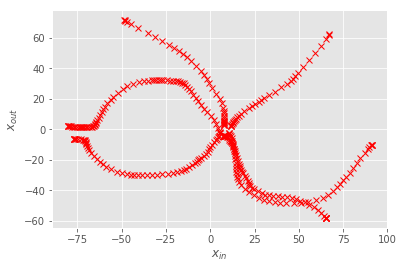

In [7]:
plt.plot(x_in[:, 0], x_in[:, 1], 'rx')
plt.xlabel(r'$x_{in}$')
plt.ylabel(r'$x_{out}$')

In [8]:
n_in = x_in.shape[1]
n_out = x_out.shape[1]
n_joint = x_joint.shape[1]
n_data = x_joint.shape[0]

### Covariance prior 

In [9]:
cov_tril = 14. * np.eye(4)
# cov_tril[2:4, :2] = -8. * np.eye(2)
cov_tril[2:4, :2] = 0. * np.eye(2)
cov = cov_tril.T.dot(cov_tril)
print cov

[[196.   0.   0.   0.]
 [  0. 196.   0.   0.]
 [  0.   0. 196.   0.]
 [  0.   0.   0. 196.]]


In [10]:
joint_model = pbd.VBayesianGMM({
        'n_components':23, 'n_init':1, 'reg_covar': 0.6 ** 2,
        'covariance_prior': cov, 'mean_precision_prior':20. ** -2,
        'weight_concentration_prior_type':'dirichlet_process', 'weight_concentration_prior': 1e3,
        'degrees_of_freedom_prior': n_joint - 1. + 0.3 })


In [11]:
joint_model.posterior(data=x_joint, dp=False)

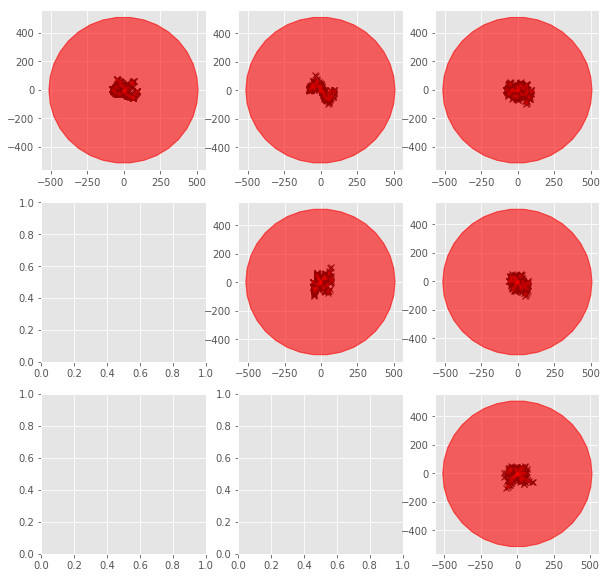

In [12]:
fig, ax = plt.subplots(nrows=n_joint-1, ncols=n_joint-1, figsize=(10, 10))

for i in range(n_joint):
    for j in range(n_joint):
        if not i == j and j>i:
            ax[i][j-1].plot(x_joint[:, i], x_joint[:, j], 'kx')
            joint_model.plot(dim=[i, j], ax=ax[i][j-1], alpha=0.2)

In [13]:
joint_model.posterior(data=x_joint)

In [14]:
def f(x, use_gmr=False):
    if use_gmr:
        return gmr_model.condition(x, slice(0, n_in), slice(n_in, n_joint))[0]
    else:
        return joint_model.condition(x, slice(0, n_in), slice(n_in, n_joint))[0]

In [15]:
def uncertainty(x):
    return -np.log(joint_model.get_pred_post_uncertainty(x, slice(0, n_in), slice(n_in, n_joint)))

### Bayesian DP-GMM policy 

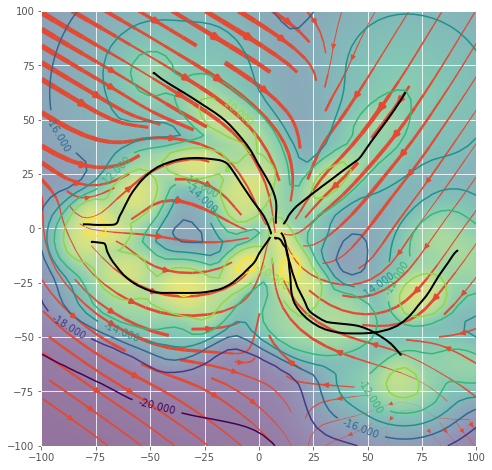

In [16]:
plt.figure(figsize=(8, 8))
pbd.plot_dynamic_system(f, xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.05)
pbd.plot_function_map(uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=80, opp=False)
# joint_model.plot(dim=[0, 1], alpha=0.2)
for d in data['x']:
    plt.plot(d[:, 0], d[:, 1], 'k', lw=2)

### Create stable controller 

In [17]:
dt = 0.05

In [18]:
A = np.eye(2)
B = dt * np.eye(2) 
T = 10

In [19]:
lqr_gmm = pbd.GMMLQR(A, B, horizon=T)

In [20]:
marg = joint_model.get_used_states().marginal_model(slice(0, 2))

In [21]:
diag = lambda x: np.eye(x.shape[-1]) * x

lqr_gmm.gmm_u = pbd.MVN(
    mu=np.zeros(2), sigma=2. * diag(np.cov(x_joint[:, 2:], rowvar=False)))


In [38]:
def stable_policy(x, t=0, xis=None, n_best=3):
    lqr_gmm.full_gmm_xi = marg
    lqr_gmm.ricatti(x, n_best=n_best)
    return lqr_gmm.K[0].dot(lqr_gmm.ds[0]-x), lqr_gmm.Q[0]

In [39]:
%timeit stable_policy(np.zeros(2), n_best=3)

100 loops, best of 3: 2.38 ms per loop


In [40]:
def stable_policy_lin(x, t=0, xis=None, n_best=3):
    lqr_gmm.full_gmm_xi = marg
    lqr_gmm.ricatti(x, n_best=n_best)
    
    return -lqr_gmm.K[0], lqr_gmm.K[0].dot(lqr_gmm.ds[0]), lqr_gmm.Q[0]

In [41]:
def stable_policy_vec(x, t=0, main_policy=None):
    s = [stable_policy(_x, t,) for _x in x]
    return np.array([_s[0] for _s in s]), np.array([_s[1] for _s in s])

## Product of policies 

In [42]:
def product_policy(x, t=0):
    mu_1, sigma_1 = joint_model.condition(x, slice(0, n_in), slice(n_in, n_joint))
    mu_2, sigma_2 = stable_policy_vec(x, t)
    
    lmbda_1, lmbda_2 = np.linalg.inv(sigma_1), np.linalg.inv(sigma_2) 
    lmbda_p = lmbda_1 + lmbda_2
    
    mu_p = np.einsum('aij,aj->ai',np.linalg.inv(lmbda_p),(np.einsum('aij,aj->ai', lmbda_1, mu_1) +
     np.einsum('aij,aj->ai', lmbda_2, mu_2)))
    return mu_p

In [43]:
def product_policy_lin(x, t=0):
    A_1, b_1, sigma_1 = joint_model.condition(
        x, slice(0, n_in), slice(n_in, n_joint), return_linear=True, tmp=True)
    
    A_2, b_2, sigma_2 = stable_policy_lin(x, t)
    
    lmbda_1, lmbda_2 = np.linalg.inv(sigma_1), np.linalg.inv(sigma_2) 
    sigma_p = np.linalg.inv(lmbda_1 + lmbda_2)
    
    A = sigma_p.dot(lmbda_1.dot(A_1) + lmbda_2.dot(A_2))
    b = sigma_p.dot(lmbda_1.dot(b_1) + lmbda_2.dot(b_2))
    
    return A, b, sigma_p

In [44]:
xiss = []
xiss_s = []
xiss_u = []

for i in range(len(data['x'])):
    n = np.random.multivariate_normal(np.zeros(2), 100. * np.eye(2))
    xis = [np.copy(data['x'][i][0]) + n]
    xis_s = [np.copy(data['x'][i][0]) + n]
    xis_u = [np.copy(data['x'][i][0]) + n]
    # xis = [np.array([-25., 25.])]

    for i in range(0, 200):
        u = product_policy(xis[-1][None], 0)[0]
        
        K, c, _ = product_policy_lin(xis[-1], 0)
        u = K.dot(xis[-1]) + c
        u_u = joint_model.condition(xis_u[-1][None], slice(0, n_in), slice(n_in, n_joint), tmp=True)[0][0]
        u_s = stable_policy(xis_s[-1], 0)[0]
        
        xis += [A.dot(xis[-1]) + B.dot(u)]
        xis_s += [A.dot(xis_s[-1]) + B.dot(u_s)]
        xis_u += [A.dot(xis_u[-1]) + B.dot(u_u)]

    xis = np.array(xis)
    xis_s = np.array(xis_s)
    xis_u = np.array(xis_u)
    
    xiss += [xis]
    xiss_s += [xis_s]
    xiss_u += [xis_u]
    

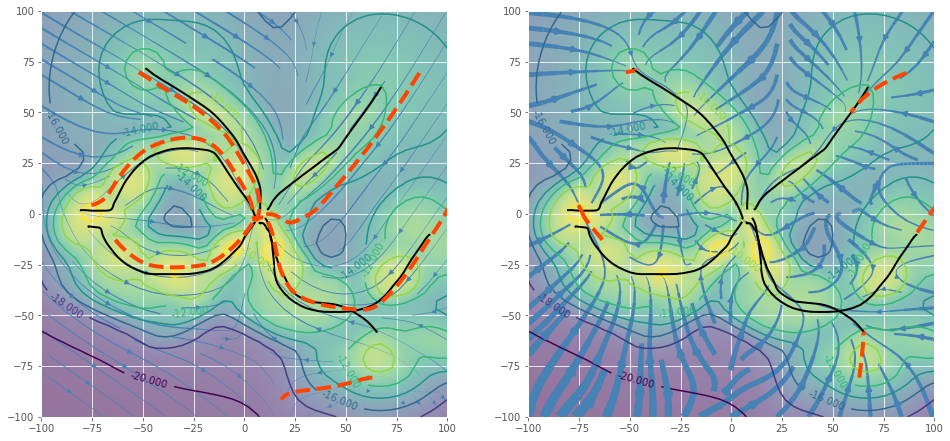

In [45]:
fig, ax= plt.subplots(ncols=2, figsize=(16, 8))

pbd.plot_dynamic_system(
    # lambda x: product_policy(x, t=0),
    lambda _x: joint_model.condition(_x, slice(0, n_in), slice(n_in, n_joint))[0],
    xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.02, ax=ax[0], 
    color='steelblue'
)

pbd.plot_dynamic_system(
    lambda x: stable_policy_vec(x, t=0, 
        main_policy=lambda _x: joint_model.condition(_x, slice(0, n_in), slice(n_in, n_joint))[0])[0],
    xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.02, ax=ax[1],
    color='steelblue'
)

for i in range(2):
    pbd.plot_function_map(
        uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=40, opp=False, ax=ax[i])

    for j, d in enumerate(data['x']):
        ax[i].plot(d[:, 0], d[:, 1], 'k', lw=2)

for j, d in enumerate(data['x']):
    ax[0].plot(xiss_u[j][:, 0], xiss_u[j][:, 1], lw=4, color='orangered', ls='--')
    ax[1].plot(xiss_s[j][:, 0], xiss_s[j][:, 1], lw=4, color='orangered', ls='--')


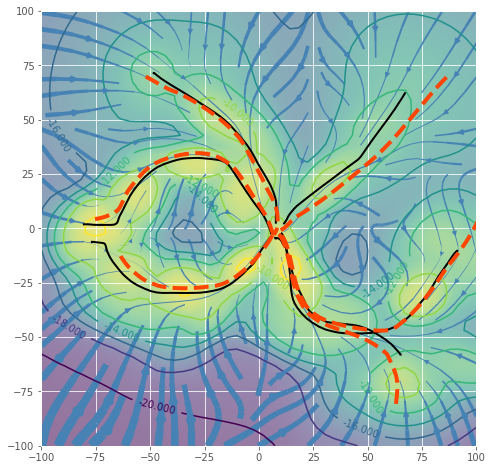

In [46]:
plt.figure(figsize=(8, 8))

pbd.plot_dynamic_system(
    lambda x: product_policy(x, t=0),
    xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.02, 
    color='steelblue'
)

pbd.plot_function_map(
    uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=40, opp=False)

for j, d in enumerate(data['x']):
    plt.plot(d[:, 0], d[:, 1], 'k', lw=2)

for j, d in enumerate(data['x']):
    plt.plot(xiss[j][:, 0], xiss[j][:, 1], lw=4, color='orangered', ls='--')


## Make a video of the process  

In [35]:
import imageio
import os

In [36]:
images = []
name = demo_name + '_dp_gmm_lqr_local'
# for t in range(0, 6, 6):
for t in range(0, T-6, 3):
    plt.figure(figsize=(8, 8))
    
    pbd.plot_dynamic_system(
        lambda x: product_policy(x, t=t),
        xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.03,
        color='steelblue'
    )
    
    pbd.plot_function_map(
        uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=40, opp=False)
    
    for d in data['x']:
        plt.plot(d[:, 0], d[:, 1], 'k--', lw=2, alpha=0.6)
        
    plt.plot(xis[:t, 0], xis[:t, 1], color='orangered', lw=3)
    plt.plot(xis[t, 0], xis[t, 1], 'ws', mec='orangered', ms=10, mew=2)
    
    plt.savefig('img_%d.png' % t)
    
    images.append(imageio.imread('img_%d.png' % t))
    os.remove('img_%d.png' % t)
    plt.close()
    
imageio.mimsave('%s.mp4' % name, images)